In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')  

In [2]:
dataDir = "Dataset"

def createTests(dataDir):
    testDir = os.path.join(dataDir, "test")
    if not os.path.exists(testDir):
        os.mkdir(testDir)
        # shutil.rmtree(testDir)
    else:
        print("Test exists")
        return

    classes = ["covid", "normal", "viral"]
    for cls in classes:
        #pick out tests
        print(cls)
        imagesDir = os.path.join(dataDir, cls, "images")
        images = os.listdir(imagesDir)
        testimage = random.sample(images, 30)
        testimage = [os.path.join(imagesDir, i) for i in testimage]
        print(testimage)
        
        #create test class folder
        clsDir = os.path.join(testDir, cls)
        os.mkdir(clsDir)
        print("Directory made", clsDir)
        
        #save tests
        for img in testimage:
            shutil.move(img, clsDir)
        print(f"{cls} data moved")

createTests(dataDir)

Test exists


In [3]:
# class ChestXRayDataset(torch.utils.data.Dataset):
#     def __init__(self, image_dirs, transform):
#         def get_images(class_name):
#             images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
#             print(f'Found {len(images)} {class_name} examples')
#             return images
        
#         self.images = {}
#         self.class_names = ['normal', 'viral', 'covid']
        
#         for class_name in self.class_names:
#             self.images[class_name] = get_images(class_name)
            
#         self.image_dirs = image_dirs
#         self.transform = transform
#         print(self.images)
        
    
#     def __len__(self):
#         return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
#     def __getitem__(self, index):
#         class_name = random.choice(self.class_names)
#         # print(class_name)
#         index = index % len(self.images[class_name])
#         # print(index)
#         image_name = self.images[class_name][index]
#         # print(image_name)
#         image_path = os.path.join(self.image_dirs[class_name], image_name)
#         image = Image.open(image_path).convert('RGB')
#         return self.transform(image), self.class_names.index(class_name)

In [4]:
# train_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(size=(224, 224)),
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize(size=(224, 224)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [5]:
class CustomTransform:
    def __init__(self, size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], horizontal_flip=True):
        self.size = size
        self.mean = np.array(mean).reshape(3, 1, 1).astype(np.float32)
        self.std = np.array(std).reshape(3, 1, 1).astype(np.float32)
        self.horizontal_flip = horizontal_flip

    def resize(self, img):
        """Resize the image to the specified size."""
        return img.resize(self.size, Image.BILINEAR)

    def random_horizontal_flip(self, img):
        """Randomly flip the image horizontally."""
        if self.horizontal_flip and random.random() > 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

    def to_numpy_array(self, img):
        """Convert a PIL Image to a numpy array in float32 format and scale pixel values to [0, 1]."""
        img_array = np.array(img).astype(np.float32) / 255.0
        return img_array.transpose((2, 0, 1))  # Change HWC to CHW

    def normalize(self, array):
        """Normalize a numpy array image with mean and standard deviation."""
        return (array - self.mean) / self.std

    def __call__(self, img):
        """Apply all transformations in sequence to the image."""
        img = self.resize(img)
        img = self.random_horizontal_flip(img)
        img_array = self.to_numpy_array(img)
        return self.normalize(img_array).astype(np.float32)

In [6]:
train_transform = CustomTransform(horizontal_flip=True)
test_transform = CustomTransform(horizontal_flip=False)

In [7]:
class datasetCreation(torch.utils.data.Dataset):
    def __init__(self, imageDir: str, transform : CustomTransform, all_classes: list):
        def get_image(individual_class):
            images = os.listdir(os.path.join(imageDir, individual_class))
            return images
        
        self.images_dict = {}
        self.transform = transform
        self.all_classes = all_classes
        self.imageDir = imageDir
        
        for i in self.all_classes:
            self.images_dict[i] = get_image(i)
        
        print(self.images_dict)
        
    def __len__(self):
        return sum([len(self.images_dict[i]) for i in self.all_classes])
    
    def __getitem__(self, idx):
        individual_class = random.choice(self.all_classes)
        idx = idx % len(self.images_dict[individual_class]) # To keep the index inside the length of the list of images in individual class
        imagename = self.images_dict[individual_class][idx]
        imagepath = os.path.join(self.imageDir, individual_class, imagename)
        image = Image.open(imagepath).convert('RGB')
        return self.transform(image), self.all_classes.index(individual_class)

In [8]:
all_classes = ["normal", "covid", "viral"]

In [9]:
train_dataset = datasetCreation(os.path.join("Dataset", "train"), train_transform, all_classes)
test_dataset = datasetCreation(os.path.join("Dataset", "test"), test_transform, all_classes)

{'normal': ['Normal-1.png', 'Normal-10.png', 'Normal-100.png', 'Normal-1000.png', 'Normal-10000.png', 'Normal-10001.png', 'Normal-10002.png', 'Normal-10003.png', 'Normal-10004.png', 'Normal-10005.png', 'Normal-10006.png', 'Normal-10007.png', 'Normal-10008.png', 'Normal-10009.png', 'Normal-1001.png', 'Normal-10010.png', 'Normal-10011.png', 'Normal-10012.png', 'Normal-10013.png', 'Normal-10014.png', 'Normal-10015.png', 'Normal-10016.png', 'Normal-10017.png', 'Normal-10018.png', 'Normal-10019.png', 'Normal-1002.png', 'Normal-10020.png', 'Normal-10021.png', 'Normal-10022.png', 'Normal-10023.png', 'Normal-10024.png', 'Normal-10025.png', 'Normal-10026.png', 'Normal-10027.png', 'Normal-10028.png', 'Normal-10029.png', 'Normal-1003.png', 'Normal-10030.png', 'Normal-10031.png', 'Normal-10032.png', 'Normal-10033.png', 'Normal-10034.png', 'Normal-10035.png', 'Normal-10036.png', 'Normal-10037.png', 'Normal-10038.png', 'Normal-10039.png', 'Normal-1004.png', 'Normal-10040.png', 'Normal-10041.png', 'N

In [10]:
# train_dirs = {
#     'normal': 'Dataset/normal/images',
#     'viral': 'Dataset/viral/images',
#     'covid': 'Dataset/COVID/images'
# }

# train_dataset = ChestXRayDataset(train_dirs, train_transform)

In [11]:
# test_dirs = {
#     'normal': 'Dataset/test/normal',
#     'viral': 'Dataset/test/viral',
#     'covid': 'Dataset/test/covid'
# }

# test_dataset = ChestXRayDataset(test_dirs, test_transform)

In [12]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2481
Number of test batches 15


In [13]:
class_names = train_dataset.all_classes


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

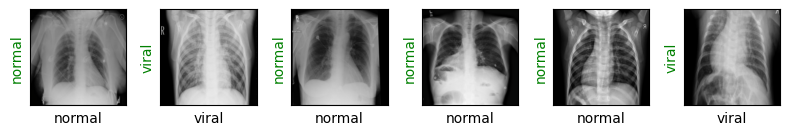

In [14]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

In [15]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [17]:
def show_preds():
    resnet18.eval() # set to evaluation mode
    images, labels = next(iter(dl_test))
    # print(images) 
    outputs = resnet18(images) 
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

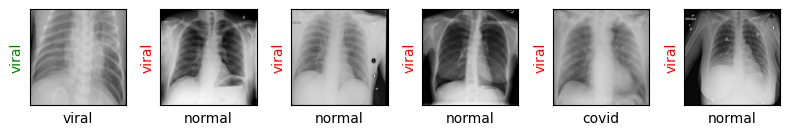

In [18]:
show_preds()

In [19]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/20
Evaluating at step 0
Validation Loss: 1.0901, Accuracy: 0.3778


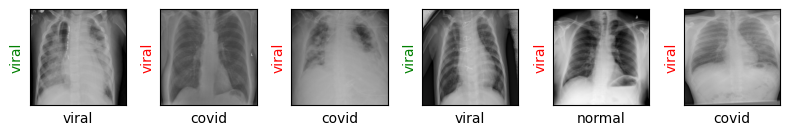

Evaluating at step 20
Validation Loss: 0.8923, Accuracy: 0.5778


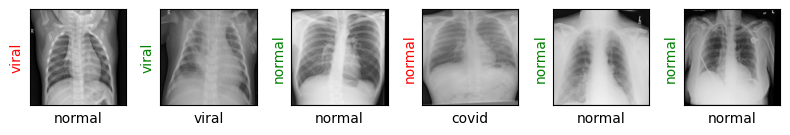

Evaluating at step 40
Validation Loss: 0.6213, Accuracy: 0.7889


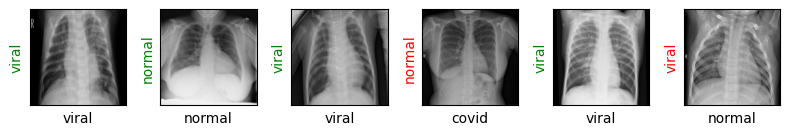

Evaluating at step 60
Validation Loss: 0.6040, Accuracy: 0.7556


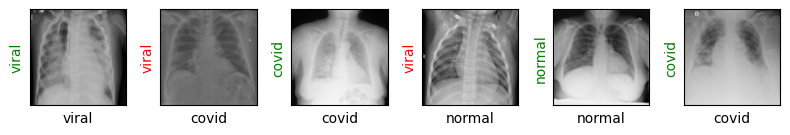

Evaluating at step 80
Validation Loss: 0.4324, Accuracy: 0.8000


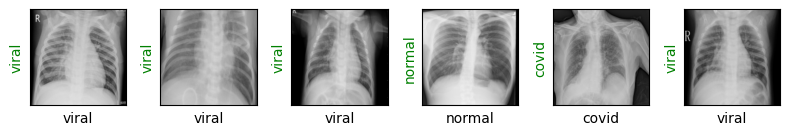

Evaluating at step 100
Validation Loss: 0.4266, Accuracy: 0.8111


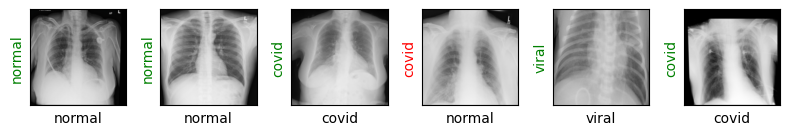

Evaluating at step 120
Validation Loss: 0.2727, Accuracy: 0.8889


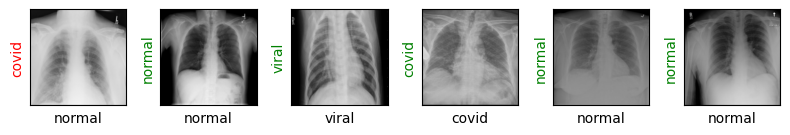

Evaluating at step 140
Validation Loss: 0.3146, Accuracy: 0.8778


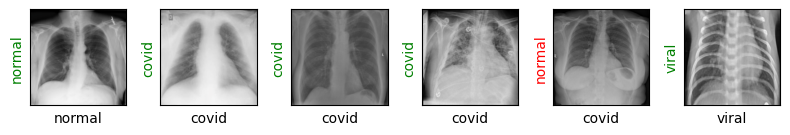

Evaluating at step 160
Validation Loss: 0.3250, Accuracy: 0.8778


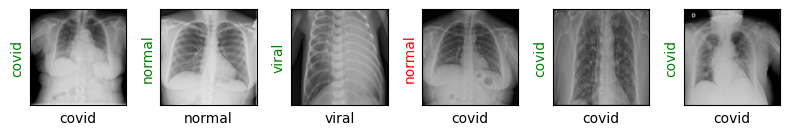

Evaluating at step 180
Validation Loss: 0.3967, Accuracy: 0.8222


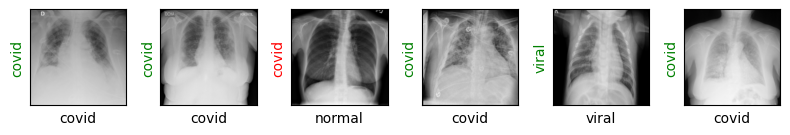

Evaluating at step 200
Validation Loss: 0.3465, Accuracy: 0.8444


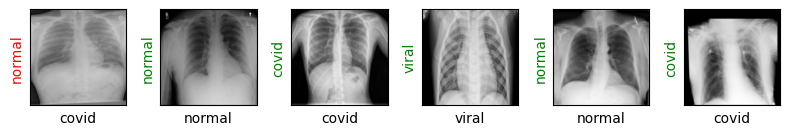

Evaluating at step 220
Validation Loss: 0.3195, Accuracy: 0.8778


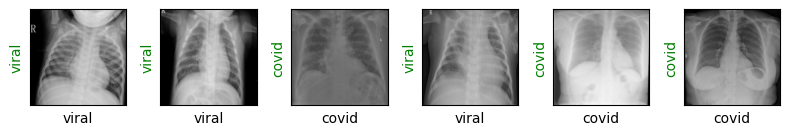

Evaluating at step 240
Validation Loss: 0.2597, Accuracy: 0.8778


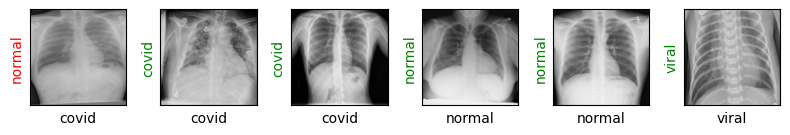

Evaluating at step 260
Validation Loss: 0.2048, Accuracy: 0.9333


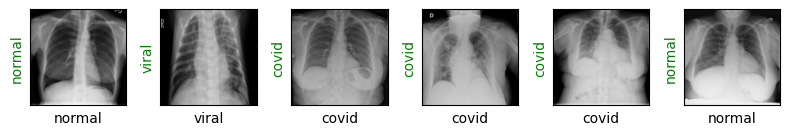

Evaluating at step 280
Validation Loss: 0.2763, Accuracy: 0.9111


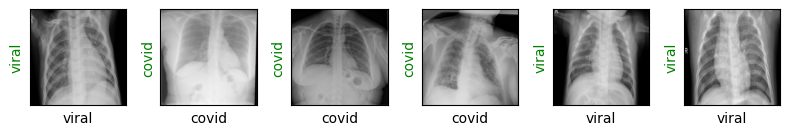

Evaluating at step 300
Validation Loss: 0.2738, Accuracy: 0.8667


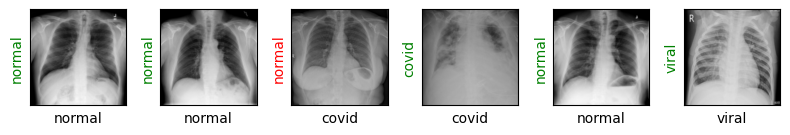

Evaluating at step 320
Validation Loss: 0.3163, Accuracy: 0.8778


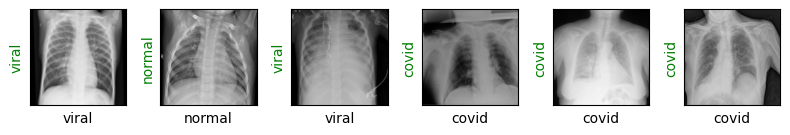

Evaluating at step 340
Validation Loss: 0.2182, Accuracy: 0.9556


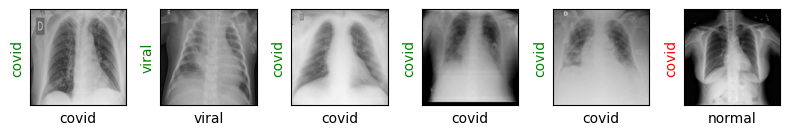

Evaluating at step 360
Validation Loss: 0.1980, Accuracy: 0.9333


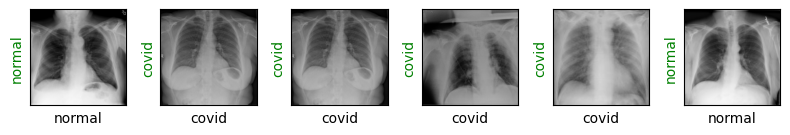

Evaluating at step 380
Validation Loss: 0.1584, Accuracy: 0.9444


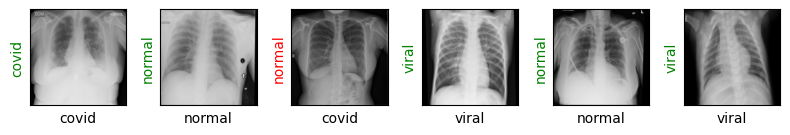

Evaluating at step 400
Validation Loss: 0.1772, Accuracy: 0.9000


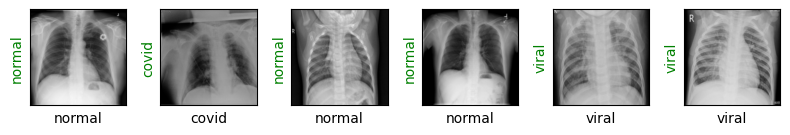

Evaluating at step 420
Validation Loss: 0.2005, Accuracy: 0.9000


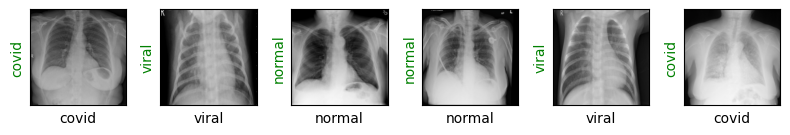

Evaluating at step 440
Validation Loss: 0.1983, Accuracy: 0.9000


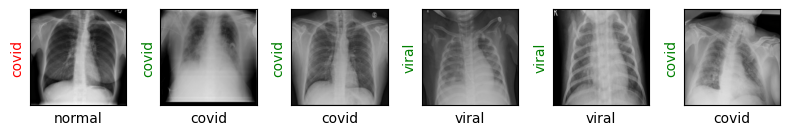

Evaluating at step 460
Validation Loss: 0.1602, Accuracy: 0.9222


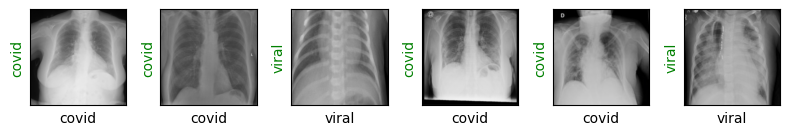

Evaluating at step 480
Validation Loss: 0.1517, Accuracy: 0.9333


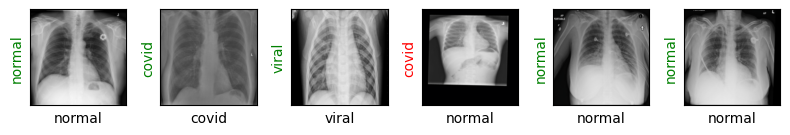

Evaluating at step 500
Validation Loss: 0.2078, Accuracy: 0.9111


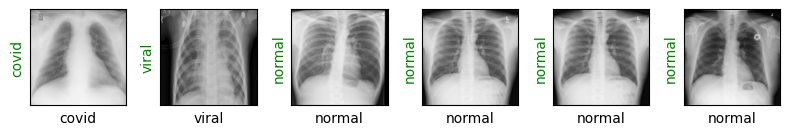

Evaluating at step 520
Validation Loss: 0.1067, Accuracy: 0.9667


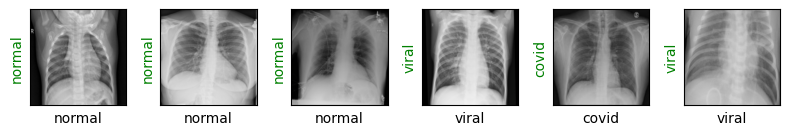

Evaluating at step 540
Validation Loss: 0.1846, Accuracy: 0.9333


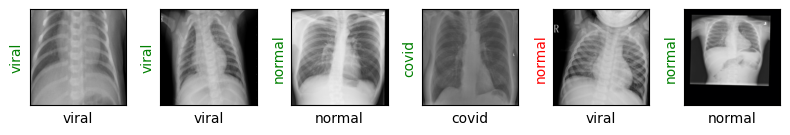

Evaluating at step 560
Validation Loss: 0.0753, Accuracy: 0.9778


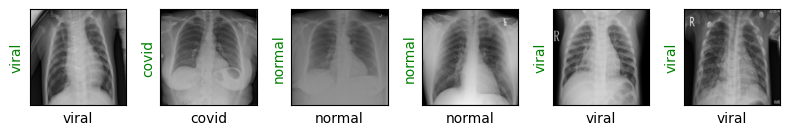

Evaluating at step 580
Validation Loss: 0.0924, Accuracy: 0.9778


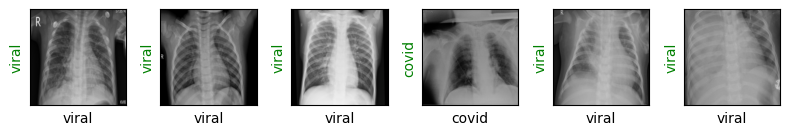

Evaluating at step 600
Validation Loss: 0.1621, Accuracy: 0.9333


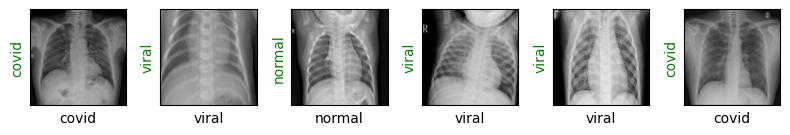

Evaluating at step 620
Validation Loss: 0.1102, Accuracy: 0.9778


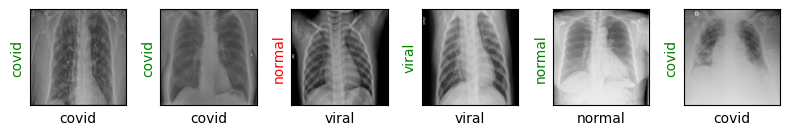

Evaluating at step 640
Validation Loss: 0.1252, Accuracy: 0.9556


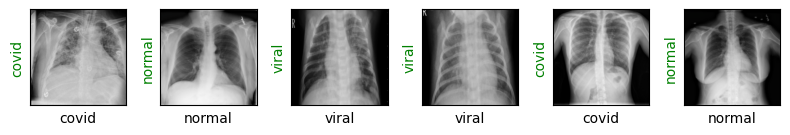

Evaluating at step 660
Validation Loss: 0.1164, Accuracy: 0.9778


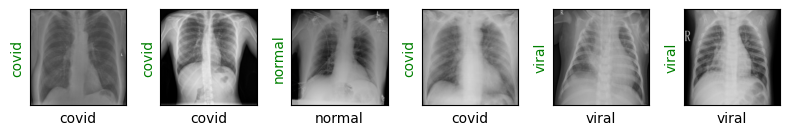

Evaluating at step 680
Validation Loss: 0.0670, Accuracy: 0.9889


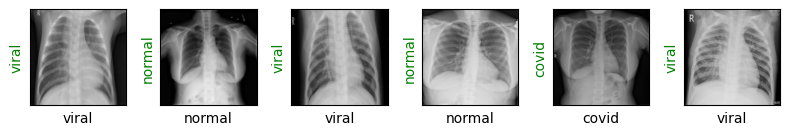

Performance condition satisfied, stopping..


In [20]:
train(epochs=20)

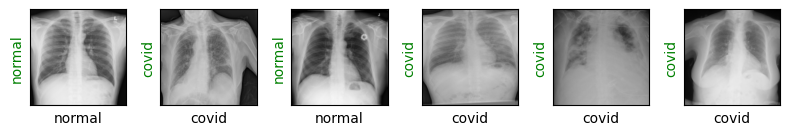

In [21]:
show_preds()

In [22]:
resnet18.eval()
random_input = torch.randn(1,3,224,224)
onnx_output_path = "ViralOrCovid.onnx"
torch.onnx.export(
    resnet18,
    random_input,
    onnx_output_path,
    export_params=True,        # Store the trained parameter weights inside the model file
              # Specify the ONNX version
    do_constant_folding=True,  # Simplify the model by folding constant nodes
    input_names=['input'],     # Define input layer name
    output_names=['output']    # Define output layer name
)

In [23]:
import onnxruntime as rt
def onnxPredictData(image, path = "ViralOrCovid.onnx") -> np.int64:
    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    class_names = ['normal', 'viral', 'covid']
    
    image = Image.open(image).convert("RGB")
    image = test_transform(image)
    image = image.unsqueeze(0)
    
    input_data = image.numpy()
    print(input_data)
    sess = rt.InferenceSession(path, providers=["CPUExecutionProvider"])
    input_name = sess.get_inputs()[0].name #input_names=['input']
    
    pred_onx = sess.run(None , {input_name : input_data})[0]
    
    # print(input_name)
    # print(image)
    # print(type(pred_onx))
    # print(pred_onx)
    predicted_class = np.argmax(pred_onx, axis=1)[0] # Finds the index of the highest item in the list or numpy array
    # print(predicted_class)
    # print(type(predicted_class))
    return class_names[predicted_class]

In [24]:
onnxPredictData("Dataset/test/covid/COVID-251.png")

[[[[-1.8267832 -1.8267832 -1.8267832 ... -1.8267832 -1.8267832
    -1.8267832]
   [-2.0836544 -2.0836544 -2.0836544 ... -2.0836544 -2.0836544
    -2.0836544]
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   ...
   [-2.117904  -2.117904  -2.117904  ... -2.117904  -2.117904
    -2.117904 ]
   [-2.0836544 -2.0836544 -2.0836544 ... -2.0836544 -2.0836544
    -2.0836544]
   [-1.8267832 -1.8267832 -1.8267832 ... -1.8267832 -1.8267832
    -1.8267832]]

  [[-1.7380952 -1.7380952 -1.7380952 ... -1.7380952 -1.7380952
    -1.7380952]
   [-2.0007002 -2.0007002 -2.0007002 ... -2.0007002 -2.0007002
    -2.0007002]
   [-2.0357141 -2.0357141 -2.0357141 ... -2.0357141 -2.0357141
    -2.0357141]
   ...
   [-2.0357141 -2.0357141 -2.0357141 ... -2.0357141 -2.0357141
    -2.0357141]
   [-2.0007002 -2.0007002 -2.0007002 ... -2.0007002 -2.0007002
    -2.0007002]
   [-1.7380952 -1.7380952 -1.7380952 ... -1.7380952 -1.7380952
    -1.7380952]]

  [[-1.5081482 -1.5081482 -1.5081482

'viral'